# Patrones de agentes

En mi post anterior expliqué cómo usar [LangGraph](https://www.maximofn.com/langgraph/) para crear agentes.

In [ ]:
%pip install -U langgraph langchain_anthropic python-dotenv tavily-python langchain_community

Así que en este vamos a ver los diferentes patrones de agentes que podemos construir y lo haremos con LangGraph.

 > **Nota**: Vamos a partir desde el modelo más básico que consiste en un chatbot con un LLM hasta llegar a arquitecturas más complejas.

 > **Nota**: Siempre que sea posible, vamos a usar `Qwen2-72B-Instruct` para poder usarlo gratis con Hugging Face.

## Respondedor de prompts (chain block)

![chain block](https://images.maximofn.com/agent_patterns_01_chain_block.webp)

Es el modelo más básico, al LLM le entra un prompt y él devuelve una respuesta.

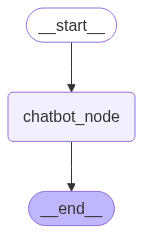

In [3]:
from typing import Annotated
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

from langchain_anthropic import ChatAnthropic

from IPython.display import Image, display

import os
os.environ["LANGCHAIN_TRACING_V2"] = "false"    # Disable LangSmith tracing

import dotenv
dotenv.load_dotenv()
ANTHROPIC_TOKEN = os.getenv("ANTHROPIC_LANGGRAPH_API_KEY")

# State
class State(TypedDict):
    messages: Annotated[list, add_messages]

# Create the LLM model
llm = ChatAnthropic(model="claude-3-7-sonnet-20250219", api_key=ANTHROPIC_TOKEN)

# Function
def chatbot_function(state: State):
    return {"messages": [llm.invoke(state["messages"])]}

# Start to build the graph
graph_builder = StateGraph(State)

# Add nodes to the graph
graph_builder.add_node("chatbot_node", chatbot_function)

# Add edges
graph_builder.add_edge(START, "chatbot_node")
graph_builder.add_edge("chatbot_node", END)

# Compile the graph
graph = graph_builder.compile()

# Display the graph
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Error al visualizar el grafo: {e}")

Vamos a probarlo

In [4]:
from langchain_core.messages import HumanMessage

messages = [HumanMessage(content="Hello, how are you?")]

result = graph.invoke({"messages": messages})
result["messages"][-1].pretty_print()

================================== Ai Message ==================================

I'm doing well, thank you for asking! How are you today?


## Cadena de bloques (chain of blocks)

![chain of blocks](https://images.maximofn.com/agent_patterns_02_chain_of_blocks.webp)

Cuando una tarea se puede dividir en varias subtareas, podemos usar una cadena de bloques. Por ejemplo, si queremos resumir y traducir un texto, podemos hacerlo en dos pasos:

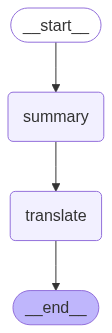

In [3]:
from typing import Annotated
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

from langchain_anthropic import ChatAnthropic
from langchain_core.messages import SystemMessage

from IPython.display import Image, display

import os
os.environ["LANGCHAIN_TRACING_V2"] = "false"    # Disable LangSmith tracing

import dotenv
dotenv.load_dotenv()
ANTHROPIC_TOKEN = os.getenv("ANTHROPIC_LANGGRAPH_API_KEY")

# State
class State(TypedDict):
    messages: Annotated[list, add_messages]

# Create the LLM model
llm = ChatAnthropic(model="claude-3-7-sonnet-20250219", api_key=ANTHROPIC_TOKEN)

# Function
def summary(state: State):
    input_text = state["messages"][-1].content
    prompt = f"Summarize the following text: {input_text}"
    llm_response = llm.invoke(prompt)
    return {"messages": [llm_response]}

def translate(state: State):
    input_text = state["messages"][-1].content
    prompt = f"Translate the following text to Spanish: {input_text}"
    llm_response = llm.invoke(prompt)
    return {"messages": [llm_response]}

# Start to build the graph
graph_builder = StateGraph(State)

# Add nodes to the graph
graph_builder.add_node("summary", summary)
graph_builder.add_node("translate", translate)

# Add edges
graph_builder.add_edge(START, "summary")
graph_builder.add_edge("summary", "translate")
graph_builder.add_edge("translate", END)

# Compile the graph
graph = graph_builder.compile()

# Display the graph
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Error al visualizar el grafo: {e}")

In [4]:
from langchain_core.messages import HumanMessage

text = """Large language models are powerful AI systems trained on vast amounts of text data.
They can generate human-like text, translate languages, write different kinds of creative content, and answer your questions in an informative way."""

messages = [HumanMessage(content=text)]

result = graph.invoke({"messages": messages})

for message in result["messages"]:
    message.pretty_print()

================================ Human Message =================================

Large language models are powerful AI systems trained on vast amounts of text data.
They can generate human-like text, translate languages, write different kinds of creative content, and answer your questions in an informative way.
================================== Ai Message ==================================

Summary: Large language models are AI systems trained on extensive text data that can generate human-like text, translate languages, create various creative content, and provide informative answers to questions.
================================== Ai Message ==================================

Resumen: Los modelos de lenguaje grande son sistemas de IA entrenados con extensos datos de texto que pueden generar texto similar al humano, traducir idiomas, crear diversos contenidos creativos y proporcionar respuestas informativas a preguntas.


## Enrutamiento (routing)

![routing](https://images.maximofn.com/agent_patterns_03_routing.webp)

Otra cosa que podemos hacer es crear varias rutas en función del problema y elegir la que mejor se adapte a nuestro problema. Vamos a ver un ejemplo en el que el usuario puede elegir entre resumir o traducir un texto.

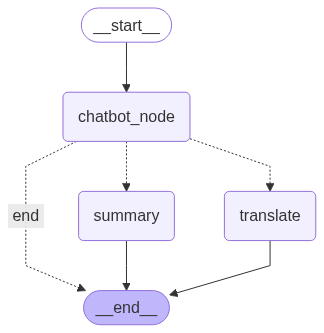

In [1]:
from typing import Annotated
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

from langchain_anthropic import ChatAnthropic
from langchain_core.messages import SystemMessage, HumanMessage

from IPython.display import Image, display

import os
os.environ["LANGCHAIN_TRACING_V2"] = "false"    # Disable LangSmith tracing

import dotenv
dotenv.load_dotenv()
ANTHROPIC_TOKEN = os.getenv("ANTHROPIC_LANGGRAPH_API_KEY")

# State
class State(TypedDict):
    messages: Annotated[list, add_messages]

# Create the LLM model
llm = ChatAnthropic(model="claude-3-7-sonnet-20250219", api_key=ANTHROPIC_TOKEN)

# Function
def chatbot_function(state: State):
    return {"messages": [llm.invoke(state["messages"])]}

def summary(state: State):
    input_text = state["messages"][-1].content
    prompt = f"Summarize the following text: {input_text}"
    llm_response = llm.invoke(prompt)
    return {"messages": [llm_response]}

def translate(state: State):
    input_text = state["messages"][-1].content
    prompt = f"Translate the following text to Spanish: {input_text}"
    llm_response = llm.invoke(prompt)
    return {"messages": [llm_response]}

# Decision function for conditional edges
def decide_next_step(state: State) -> str:
    """
    Decides the next step after the chatbot_node.
    It checks the user's last message for keywords like 'summarize' or 'translate'.
    """
    # Filter out human messages from the state
    user_messages = [msg for msg in state["messages"] if isinstance(msg, HumanMessage)]

    if not user_messages:
        # If there are no human messages, default to ending the process
        return "end"

    # Get the content of the last human message
    last_user_message_content = user_messages[-1].content.lower()

    if "summarize" in last_user_message_content or "resumir" in last_user_message_content:
        # If the user asked to summarize
        return "summary"
    elif "translate" in last_user_message_content or "traducir" in last_user_message_content:
        # If the user asked to translate
        return "translate"
    else:
        # Otherwise, end the process
        return "end"

# Start to build the graph
graph_builder = StateGraph(State)

# Add nodes to the graph
graph_builder.add_node("chatbot_node", chatbot_function)
graph_builder.add_node("summary", summary)
graph_builder.add_node("translate", translate)

# Add edges
graph_builder.add_edge(START, "chatbot_node")

# Add conditional edges from chatbot_node
# The decide_next_step function will determine which path to take
graph_builder.add_conditional_edges(
    "chatbot_node",         # The node where the decision is made
    decide_next_step,       # The function that makes the decision
    {                       # A dictionary mapping decision outcomes to next nodes
        "summary": "summary",   # If decide_next_step returns "summary", go to the "summary" node
        "translate": "translate", # If decide_next_step returns "translate", go to the "translate" node
        "end": END              # If decide_next_step returns "end", end the graph
    }
)

# Add edges to end the graph after summary or translate
graph_builder.add_edge("summary", END)
graph_builder.add_edge("translate", END)

# Compile the graph
graph = graph_builder.compile()

# Display the graph
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Error al visualizar el grafo: {e}")

In [2]:
from langchain_core.messages import HumanMessage

text = """Large language models are powerful AI systems trained on vast amounts of text data.
They can generate human-like text, translate languages, write different kinds of creative content, and answer your questions in an informative way."""

prompt = f"Summarize the following text: {text}"

messages = [HumanMessage(content=prompt)]

result = graph.invoke({"messages": messages})

for message in result["messages"]:
    message.pretty_print()

================================ Human Message =================================

Summarize the following text: Large language models are powerful AI systems trained on vast amounts of text data.
They can generate human-like text, translate languages, write different kinds of creative content, and answer your questions in an informative way.
================================== Ai Message ==================================

The text explains that large language models are AI systems trained on extensive text datasets, enabling them to generate text similar to human writing, perform translations, create various creative content, and provide informative answers to questions.
================================== Ai Message ==================================

# Summary

Large language models are AI systems trained on vast text datasets that can generate human-like text, translate languages, create creative content, and answer questions informatively.


In [3]:
from langchain_core.messages import HumanMessage

text = """Large language models are powerful AI systems trained on vast amounts of text data.
They can generate human-like text, translate languages, write different kinds of creative content, and answer your questions in an informative way."""

prompt = f"Translate the following text to Spanish: {text}"

messages = [HumanMessage(content=prompt)]

result = graph.invoke({"messages": messages})

for message in result["messages"]:
    message.pretty_print()

================================ Human Message =================================

Translate the following text to Spanish: Large language models are powerful AI systems trained on vast amounts of text data.
They can generate human-like text, translate languages, write different kinds of creative content, and answer your questions in an informative way.
================================== Ai Message ==================================

Los modelos de lenguaje grandes son sistemas de IA potentes entrenados con enormes cantidades de datos textuales.
Pueden generar texto similar al humano, traducir idiomas, escribir diferentes tipos de contenido creativo y responder a tus preguntas de manera informativa.
================================== Ai Message ==================================

"Los modelos de lenguaje grandes son sistemas de IA potentes entrenados con enormes cantidades de datos textuales.
Pueden generar texto similar al humano, traducir idiomas, escribir diferentes tipos de contenid

## Paralelización (parallelization)

![parallelization](https://images.maximofn.com/agent_patterns_04_paralellitation.webp)

Cuando una tarea es muy importante o compleja podemos paralelizarla para que la ejecuten diferentes LLMs. Después le pasamos el resultado a un LLM para que pueda combinarlos. Vamos a ver un ejemplo en el que tenemos tres LLMs que resumen un texto de manera diferente y luego lo combinamos.

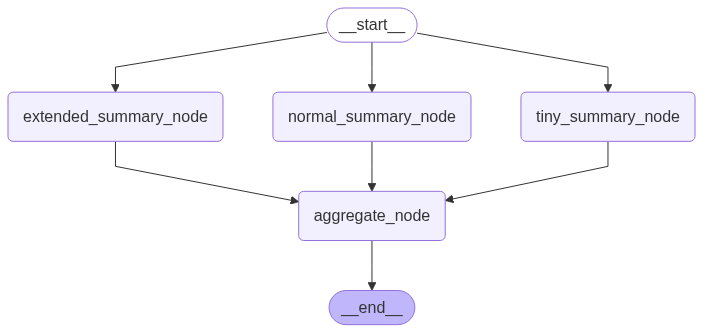

In [4]:
from typing import Annotated
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

from langchain_anthropic import ChatAnthropic
from langchain_core.messages import SystemMessage, HumanMessage

from IPython.display import Image, display

import os
os.environ["LANGCHAIN_TRACING_V2"] = "false"    # Disable LangSmith tracing

import dotenv
dotenv.load_dotenv()
ANTHROPIC_TOKEN = os.getenv("ANTHROPIC_LANGGRAPH_API_KEY")

# State
class State(TypedDict):
    messages: Annotated[list, add_messages]
    tiny_summary: str
    normal_summary: str
    extended_summary: str

# Create the LLM model
llm = ChatAnthropic(model="claude-3-7-sonnet-20250219", api_key=ANTHROPIC_TOKEN)

# Function
def tiny_summary(state: State):
    input_text = state["messages"][-1].content
    prompt = f"Summarize the following text in 10 words: {input_text}"
    llm_response = llm.invoke(prompt)
    return {"messages": [llm_response], "tiny_summary": llm_response.content}

def normal_summary(state: State):
    input_text = state["messages"][-1].content
    prompt = f"Summarize the following text: {input_text}"
    llm_response = llm.invoke(prompt)
    return {"messages": [llm_response], "normal_summary": llm_response.content}

def extended_summary(state: State):
    input_text = state["messages"][-1].content
    prompt = f"Summarize the following text in 100 words: {input_text}"
    llm_response = llm.invoke(prompt)
    return {"messages": [llm_response], "extended_summary": llm_response.content}

def aggregate(state: State):
    prompt = f"Combine the following summaries into a single one: {state['tiny_summary']}, {state['normal_summary']}, {state['extended_summary']}"
    llm_response = llm.invoke(prompt)
    return {"messages": [llm_response]}

# Start to build the graph
graph_builder = StateGraph(State)

# Add nodes to the graph
graph_builder.add_node("tiny_summary_node", tiny_summary)
graph_builder.add_node("normal_summary_node", normal_summary)
graph_builder.add_node("extended_summary_node", extended_summary)
graph_builder.add_node("aggregate_node", aggregate)

# Add edges
graph_builder.add_edge(START, "tiny_summary_node")
graph_builder.add_edge(START, "normal_summary_node")
graph_builder.add_edge(START, "extended_summary_node")
graph_builder.add_edge("tiny_summary_node", "aggregate_node")
graph_builder.add_edge("normal_summary_node", "aggregate_node")
graph_builder.add_edge("extended_summary_node", "aggregate_node")
graph_builder.add_edge("aggregate_node", END)

# Compile the graph
graph = graph_builder.compile()

# Display the graph
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Error al visualizar el grafo: {e}")

In [5]:
from langchain_core.messages import HumanMessage

text = """Large language models are powerful AI systems trained on vast amounts of text data.
They can generate human-like text, translate languages, write different kinds of creative content, and answer your questions in an informative way."""

messages = [HumanMessage(content=text)]

result = graph.invoke({"messages": messages})

for message in result["messages"]:
    message.pretty_print()

================================ Human Message =================================

Large language models are powerful AI systems trained on vast amounts of text data.
They can generate human-like text, translate languages, write different kinds of creative content, and answer your questions in an informative way.
================================== Ai Message ==================================

Large language models (LLMs) are sophisticated AI systems that learn from extensive text datasets. These models have impressive capabilities, including generating text that resembles human writing, performing language translation, creating various forms of creative content, and providing informative responses to questions. Their versatility and ability to understand and produce natural language make them valuable tools across numerous applications.
================================== Ai Message ==================================

Summary: Large language models are AI systems trained on extensive te

## Evaluador-optimizador (reflection pattern)

![reflection pattern](https://images.maximofn.com/agent_patterns_05_reflection_pattern.webp)

Otra manera de resolver tareas complejas es tener un LLM para resolver la tarea y otro LLM para evaluar el resultado, de manera que se ejecutan en bucle, hasta que el evaluador considera que el trabajo ha finalizado correctamente. Vamos a ver un ejemplo en el que un LLM suma 1 a un número y otro comprueba si el número es 10.

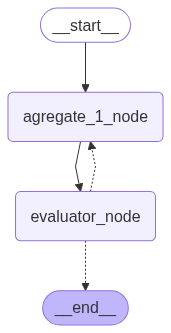

In [6]:
from typing import Annotated
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

from langchain_anthropic import ChatAnthropic
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage

from IPython.display import Image, display

import os
os.environ["LANGCHAIN_TRACING_V2"] = "false"    # Disable LangSmith tracing

import dotenv
dotenv.load_dotenv()
ANTHROPIC_TOKEN = os.getenv("ANTHROPIC_LANGGRAPH_API_KEY")

# State
class State(TypedDict):
    messages: Annotated[list, add_messages]
    number: int
    evaluator: str

# Create the LLM model
llm = ChatAnthropic(model="claude-3-7-sonnet-20250219", api_key=ANTHROPIC_TOKEN)

# Function
def agregate_1(state: State):
    if state.get("number", None) is None:
        input_text = state["messages"][-1].content
        prompt = f"Get the number from the following text: {input_text}. Respond only with the number."
        number_str = llm.invoke(prompt)
        number = int(number_str.content)
        state["number"] = number

    number_state = state["number"]
    number_plus_1 = number_state + 1
    response = AIMessage(content=f"[Agregator] --> The number is {number_state} and the next number is {number_plus_1}")
    return {"messages": [response], "number": number_plus_1, "evaluator": "no"}

def evaluator(state: State):
    prompt = f"Is the following number {state['number']} equal to 10? Respond only with 'yes' or 'no'."
    result = llm.invoke(prompt)
    number_state = state["number"]
    response = AIMessage(content=f"[Evaluator] --> Is the following number {number_state} equal to 10? Result: {result.content}")
    return {"messages": [response], "evaluator": result.content, "number": number_state}

def decide_next_step(state: State):
    if state["evaluator"] == "yes":
        return END
    else:
        return "agregate_1_node"

# Start to build the graph
graph_builder = StateGraph(State)

# Add nodes to the graph
graph_builder.add_node("agregate_1_node", agregate_1)
graph_builder.add_node("evaluator_node", evaluator)

# Add edges
graph_builder.add_edge(START, "agregate_1_node")
graph_builder.add_edge("agregate_1_node", "evaluator_node")
graph_builder.add_conditional_edges(
    "evaluator_node",
    decide_next_step,
    {
        "agregate_1_node": "agregate_1_node",
        END: END
    }
)

# Compile the graph
graph = graph_builder.compile()

# Display the graph
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Error al visualizar el grafo: {e}")

In [7]:
from langchain_core.messages import HumanMessage

prompt = "Start the process with the number 1"

messages = [HumanMessage(content=prompt)]

result = graph.invoke({"messages": messages}, {"number": None})

for message in result["messages"]:
    message.pretty_print()

================================ Human Message =================================

Start the process with the number 1
================================== Ai Message ==================================

[Agregator] --> The number is 1 and the next number is 2
================================== Ai Message ==================================

[Evaluator] --> Is the following number 2 equal to 10? Result: no
================================== Ai Message ==================================

[Agregator] --> The number is 2 and the next number is 3
================================== Ai Message ==================================

[Evaluator] --> Is the following number 3 equal to 10? Result: no
================================== Ai Message ==================================

[Agregator] --> The number is 3 and the next number is 4
================================== Ai Message ==================================

[Evaluator] --> Is the following number 4 equal to 10? Result: no
=====================

## Agente con herramientas (ReAct pattern)

![ReAct pattern](https://images.maximofn.com/agent_patterns_06_react_pattern.webp)

Otra posibilidad es poder darle herramientas al agente

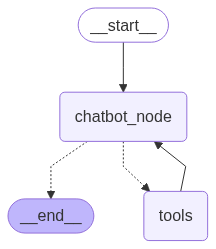

In [9]:
from typing import Annotated
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

from langchain_anthropic import ChatAnthropic
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage
from langchain_core.tools import tool

from IPython.display import Image, display

import os
os.environ["LANGCHAIN_TRACING_V2"] = "false"    # Disable LangSmith tracing

import dotenv
dotenv.load_dotenv()
ANTHROPIC_TOKEN = os.getenv("ANTHROPIC_LANGGRAPH_API_KEY")

# State
class State(TypedDict):
    messages: Annotated[list, add_messages]

# Tools
@tool
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int

    Returns:
        The product of a and b.
    """
    return a * b

tools_list = [multiply]

# Create the LLM model
llm = ChatAnthropic(model="claude-3-7-sonnet-20250219", api_key=ANTHROPIC_TOKEN)
llm_with_tools = llm.bind_tools(tools_list)

# Function
def chatbot_function(state: State):
    system_message = "You are a helpful assistant that can use tools to answer questions. Once you have the result of a tool, provide a final answer without calling more tools."
    messages = [SystemMessage(content=system_message)] + state["messages"]
    return {"messages": [llm_with_tools.invoke(messages)]}

# Start to build the graph
graph_builder = StateGraph(State)

# Add nodes to the graph
graph_builder.add_node("chatbot_node", chatbot_function)
tool_node = ToolNode(tools=tools_list)
graph_builder.add_node("tools", tool_node)

# Add edges
graph_builder.add_edge(START, "chatbot_node")
graph_builder.add_conditional_edges("chatbot_node", tools_condition)
graph_builder.add_edge("tools", "chatbot_node")
graph_builder.add_edge("chatbot_node", END)

# Compile the graph
graph = graph_builder.compile()

# Display the graph
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Error al visualizar el grafo: {e}")

In [10]:
from langchain_core.messages import HumanMessage

prompt = "Multiply 2 and 3"

messages = [HumanMessage(content=prompt)]

result = graph.invoke({"messages": messages}, {"number": None})

for message in result["messages"]:
    message.pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================

[{'text': "I'll help you multiply 2 and 3 using the available tool.", 'type': 'text'}, {'id': 'toolu_01HKo8WPhPVuzKm8x2BLZCcs', 'input': {'a': 2, 'b': 3}, 'name': 'multiply', 'type': 'tool_use'}]
Tool Calls:
  multiply (toolu_01HKo8WPhPVuzKm8x2BLZCcs)
 Call ID: toolu_01HKo8WPhPVuzKm8x2BLZCcs
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: multiply

6
================================== Ai Message ==================================

The product of 2 and 3 is 6.


## Planning pattern

![planning pattern](https://images.maximofn.com/agent_patterns_07_planning_pattern.webp)

En este caso un LLM divide el problema en varias tareas y se las asigna a otros agentes, después otro LLM combina las respuestas de los agentes para dar una respuesta final. Vamos a ver el problema de resumir y traducir un texto.

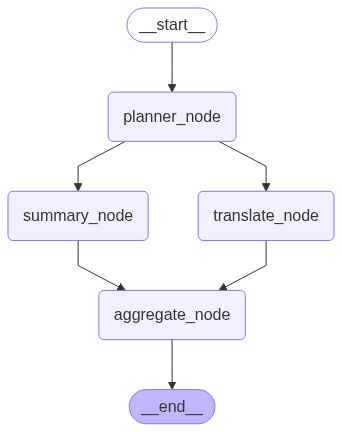

In [11]:
from typing import Annotated
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

from langchain_anthropic import ChatAnthropic
from langchain_core.messages import SystemMessage, HumanMessage

from IPython.display import Image, display

import os
os.environ["LANGCHAIN_TRACING_V2"] = "false"    # Disable LangSmith tracing

import dotenv
dotenv.load_dotenv()
ANTHROPIC_TOKEN = os.getenv("ANTHROPIC_LANGGRAPH_API_KEY")

# State
class State(TypedDict):
    messages: Annotated[list, add_messages]
    text_to_summarize: str
    text_to_translate: str
    summary: str
    translation: str
# Create the LLM model
llm = ChatAnthropic(model="claude-3-7-sonnet-20250219", api_key=ANTHROPIC_TOKEN)

# Function
def planner_function(state: State):
    input_text = state["messages"][-1].content
    text_to_summarize = f"Summarize the following text: {input_text}"
    text_to_translate = f"Translate the following text to Spanish: {input_text}"
    return {
        "text_to_summarize": text_to_summarize,
        "text_to_translate": text_to_translate
    }

def summary_function(state: State):
    input_text = state["text_to_summarize"]
    llm_response = llm.invoke(input_text)
    summary = llm_response.content
    return {"messages": [llm_response], "summary": summary}

def translate_function(state: State):
    input_text = state["text_to_translate"]
    llm_response = llm.invoke(input_text)
    translation = llm_response.content
    return {"messages": [llm_response], "translation": translation}

def aggregate_function(state: State):
    prompt = f"""Combine the following summary and translation into a single one:
    SUMMARY: {state['summary']}
    TRANSLATION: {state['translation']}"""
    llm_response = llm.invoke(prompt)
    return {"messages": [llm_response]}

# Start to build the graph
graph_builder = StateGraph(State)

# Add nodes to the graph
graph_builder.add_node("planner_node", planner_function)
graph_builder.add_node("summary_node", summary_function)
graph_builder.add_node("translate_node", translate_function)
graph_builder.add_node("aggregate_node", aggregate_function)

# Add edges
graph_builder.add_edge(START, "planner_node")
graph_builder.add_edge("planner_node", "summary_node")
graph_builder.add_edge("planner_node", "translate_node")
graph_builder.add_edge("summary_node", "aggregate_node")
graph_builder.add_edge("translate_node", "aggregate_node")
graph_builder.add_edge("aggregate_node", END)

# Compile the graph
graph = graph_builder.compile()

# Display the graph
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Error al visualizar el grafo: {e}")

In [12]:
from langchain_core.messages import HumanMessage

text = """Large language models are powerful AI systems trained on vast amounts of text data.
They can generate human-like text, translate languages, write different kinds of creative content, and answer your questions in an informative way."""

messages = [HumanMessage(content=text)]

result = graph.invoke({"messages": messages})

for message in result["messages"]:
    message.pretty_print()

================================ Human Message =================================

Large language models are powerful AI systems trained on vast amounts of text data.
They can generate human-like text, translate languages, write different kinds of creative content, and answer your questions in an informative way.
================================== Ai Message ==================================

The text explains that large language models are AI systems trained on extensive text datasets. These models have multiple capabilities, including generating text similar to human writing, translating between languages, creating various creative content, and providing informative answers to questions.
================================== Ai Message ==================================

Los modelos de lenguaje grandes son sistemas de IA potentes entrenados con grandes cantidades de datos textuales.
Pueden generar texto similar al humano, traducir idiomas, escribir diferentes tipos de contenido creativo

## Multi agent pattern

![multi agent pattern](https://images.maximofn.com/agent_patterns_08_multi_agent_pattern.webp)

En este caso tenemos un agente coordinador que se encarga de asignar tareas a los agentes. Además, los agentes se pueden pedir tareas entre ellos

Este sería un posible flujo de trabajo:

![multi agent workflow](https://images.maximofn.com/agent_patterns_08_multi_agent_workflow.webp)

Vamos a hacer un pequeño deep researcher

### Worker 1: Agente buscador de noticias

Creamos el primer worker, un agente que se encarga de buscar en internet y generar amplios informes, le pido más de 200 palabras. Además, le voy a crear un checkpoint, para que tenga contexto de lo que ya ha buscado.

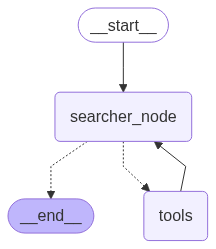

In [14]:
from typing import Annotated
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

from langchain_anthropic import ChatAnthropic

from langchain_community.utilities.tavily_search import TavilySearchAPIWrapper
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import SystemMessage, ToolMessage

from langgraph.prebuilt import ToolNode, tools_condition

from langgraph.checkpoint.memory import MemorySaver

from IPython.display import Image, display

import os
os.environ["LANGCHAIN_TRACING_V2"] = "false"    # Disable LangSmith tracing

import dotenv
dotenv.load_dotenv()
ANTHROPIC_TOKEN = os.getenv("ANTHROPIC_LANGGRAPH_API_KEY")
TAVILY_API_KEY = os.getenv("TAVILY_LANGGRAPH_API_KEY")

# State
class State_searcher(TypedDict):
    messages: Annotated[list, add_messages]

# Tools
wrapper = TavilySearchAPIWrapper(tavily_api_key=TAVILY_API_KEY)
tool_search = TavilySearchResults(api_wrapper=wrapper, max_results=10)
tools_searcher_list = [tool_search]

# Create the LLM model
llm_searcher = ChatAnthropic(model="claude-3-7-sonnet-20250219", api_key=ANTHROPIC_TOKEN)
# Create the LLM with tools
llm_searcher_with_tools = llm_searcher.bind_tools(tools_searcher_list)

# Tool node
tool_searcher_node = ToolNode(tools=tools_searcher_list)

# Functions
def searcher_function(state: State_searcher):
    # Check if the last message is a ToolMessage
    if state["messages"] and isinstance(state["messages"][-1], ToolMessage):
        # If it is, it means the tool has run, so we pass the messages as they are.
        return {"messages": state["messages"]}

    system_prompt = """You are a helpful assistant.
    Your task is to decide if you need to search the web for information based on the user's query.
    If you need to search the web, invoke the available search tool.
    Do NOT process or summarize the search results. Simply return the raw output from the search tool.
    If you don't need to search, respond to the user directly.
    The document must to have more than 200 words.
    """
    messages = [SystemMessage(content=system_prompt)] + state["messages"]
    return {"messages": [llm_searcher_with_tools.invoke(messages)]}

# Start to build the graph
graph_searcher = StateGraph(State_searcher)

# Add nodes to the graph
graph_searcher.add_node("searcher_node", searcher_function)
graph_searcher.add_node("tools", tool_searcher_node)

# Add edges
graph_searcher.add_edge(START, "searcher_node")
graph_searcher.add_conditional_edges( "searcher_node", tools_condition)
graph_searcher.add_edge("tools", "searcher_node")

# Compile the graph
memory_searcher = MemorySaver()
graph_searcher_compiled = graph_searcher.compile(checkpointer=memory_searcher)

# Display the graph
try:
    display(Image(graph_searcher_compiled.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Error al visualizar el grafo: {e}")

Vamos a probarlo, le voy a pedir los finalistas de la Champions League de este año (2025), que lógicamente no está en el conocimiento del LLM

In [15]:
from langchain_core.messages import HumanMessage

USER1_THREAD_ID = "1"
config_USER1 = {"configurable": {"thread_id": USER1_THREAD_ID}}

prompt = "Who are the Champions League 2025 finalists?"

messages = [HumanMessage(content=prompt)]

result_searcher = graph_searcher_compiled.invoke({"messages": messages}, config=config_USER1)

for message in result_searcher["messages"]:
    message.pretty_print()

================================ Human Message =================================

Who are the Champions League 2025 finalists?
================================== Ai Message ==================================

[{'text': 'I need to search for current information about the Champions League 2025 finalists, as this is a question about a future or recent sporting event that requires up-to-date information.', 'type': 'text'}, {'id': 'toolu_01Ji44XJNoDwwoUp9mmPWuG4', 'input': {'query': 'Champions League 2025 finalists'}, 'name': 'tavily_search_results_json', 'type': 'tool_use'}]
Tool Calls:
  tavily_search_results_json (toolu_01Ji44XJNoDwwoUp9mmPWuG4)
 Call ID: toolu_01Ji44XJNoDwwoUp9mmPWuG4
  Args:
    query: Champions League 2025 finalists
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "2025 UEFA Champions League final: Munich Football Arena", "url": "https://www.uefa.com/uefachampionsleague/news/0283-186742eb3c74

Nos ha devuelto una lista de resultados de la búsqueda, ahora vamos a sintetizarla.

### Worker 2: agente sintetizador de noticias

Ahora creamos el segundo worker, un agente que se encarga de sintetizar la información de los informes de los otros agentes.

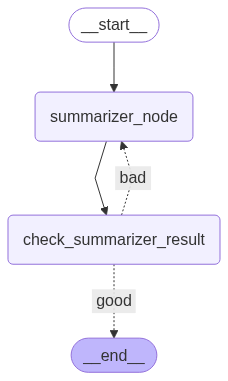

In [16]:
# State
class State_summarizer(TypedDict):
    messages: Annotated[list, add_messages]
    decision: str

# Create the LLM model
llm_summarizer = ChatAnthropic(model="claude-3-7-sonnet-20250219", api_key=ANTHROPIC_TOKEN)

# Functions
def summarizer_function(state: State_summarizer):
    system_prompt = """You are an advanced AI assistant specialized in summarizing complex information from multiple documents.
    Your task is to process a list of provided documents (typically search results) and generate a comprehensive yet concise summary.

    Key objectives for your summary:
    1.  **Accuracy:** Ensure all information is derived strictly from the provided documents. Do not infer or add external knowledge.
    2.  **Relevance:** Focus on the most important facts, findings, and answers related to the core topic of the documents.
    3.  **Clarity:** Write in clear, precise, and easily understandable language. Define any jargon if present in the source and necessary for understanding.
    4.  **Structure:** Organize the summary logically. Use paragraphs to separate distinct ideas. If helpful for the content, consider using bullet points for lists of key facts or findings.
    5.  **Conciseness:** Be thorough but avoid unnecessary repetition or overly verbose phrasing. Capture the essence efficiently.
    6.  **Neutrality:** Maintain an objective tone.

    Synthesize the information into a coherent piece that gives a full picture of what the documents collectively state about the topic.
    """ # End of the new system_prompt
    messages = [SystemMessage(content=system_prompt)] + state["messages"]
    summarizer_result = llm_summarizer.invoke(messages)
    return {"messages": [summarizer_result]}

def check_summarizer_result(state: State_summarizer):
    system_prompt = """You are a critical reviewer AI, tasked with validating text summaries against specific quality criteria.
    You will receive an original text and a summary generated from it. The summary was intended to meet the following objectives:
    - Accuracy (derived strictly from the original, no external knowledge).
    - Relevance (focus on most important facts related to the core topic).
    - Clarity (clear, precise, easily understandable language).
    - Good Structure (logically organized, paragraphs/bullets if appropriate).
    - Conciseness (thorough but not verbose).
    - Neutrality (objective tone).

    Carefully compare the summary against the original text.
    If the summary successfully meets ALL the above objectives, return the single word "good".
    If the summary fails to meet one or more of these objectives adequately, return the single word "bad".
    Provide only "good" or "bad" as your response.
    """ # End of new system_prompt

    text_to_summarize = state["messages"][-2].content

    summarizer_result = state["messages"][-1].content

    prompt = f"""
    Here is the summary:
    {summarizer_result}

    And here is the original text:
    {text_to_summarize}

    Please, return only one word, "good" or "bad".
    """
    messages = [SystemMessage(content=system_prompt)] + [HumanMessage(content=prompt)]
    decision = llm_summarizer.invoke(messages)
    return {"decision": decision.content}

# Start to build the graph
graph_summarizer = StateGraph(State_summarizer)

# Add nodes to the graph
graph_summarizer.add_node("summarizer_node", summarizer_function)
graph_summarizer.add_node("check_summarizer_result", check_summarizer_result)
# Add edges
graph_summarizer.add_edge(START, "summarizer_node")
graph_summarizer.add_edge("summarizer_node", "check_summarizer_result")
graph_summarizer.add_conditional_edges(
    source="check_summarizer_result",
    path=lambda state: state["decision"],
    path_map={
        "good": END,
        "bad": "summarizer_node"
    }
)

# Compile the graph
memory_summarizer = MemorySaver()
graph_summarizer_compiled = graph_summarizer.compile(checkpointer=memory_summarizer)

# Display the graph
try:
    display(Image(graph_summarizer_compiled.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Error al visualizar el grafo: {e}")

Vamos a probarlo, le voy a pasar el resultado del primer worker para ver cómo lo sintetiza.

In [17]:
search_result = result_searcher["messages"][-1].content

messages = [HumanMessage(content=search_result)]

result_sumarizer = graph_summarizer_compiled.invoke({"messages": messages}, config=config_USER1)

for message in result_sumarizer["messages"]:
    message.pretty_print()

print("\nDecision on Summary:")
decision = result_sumarizer.get("decision")
if decision:
    print(decision)
else:
    print("No decision was found.")

print("--- End of Summarizer Graph Output ---")

================================ Human Message =================================

[{"title": "2025 UEFA Champions League final: Munich Football Arena", "url": "https://www.uefa.com/uefachampionsleague/news/0283-186742eb3c74-d5eb4afca229-1000--2025-uefa-champions-league-final-munich-football-arena/", "content": "The 2025 Champions League final between Paris and Inter takes place on Saturday 31 May 2025. It will be culmination of the 70th season of", "score": 0.86632514}, {"title": "2025 UEFA Champions League final - Wikipedia", "url": "https://en.wikipedia.org/wiki/2025_UEFA_Champions_League_final", "content": "10.   **[^](https://en.wikipedia.org/wiki/2025_UEFA_Champions_League_final#cite_ref-11)**Benge, James; Booth, Chuck (31 May 2025). [\"Paris Saint-Germain vs. Inter score: PSG crowned Champions League winners for first time with blowout victory\"](https://www.cbssports.com/soccer/news/paris-saint-germain-vs-inter-score-psg-crowned-champions-league-winners-for-first-time-with-blowo

Vemos que ha hecho un resumen de las noticias

### Grafo principal

Una vez tenemos los dos workers, podemos construir el grafo principal.

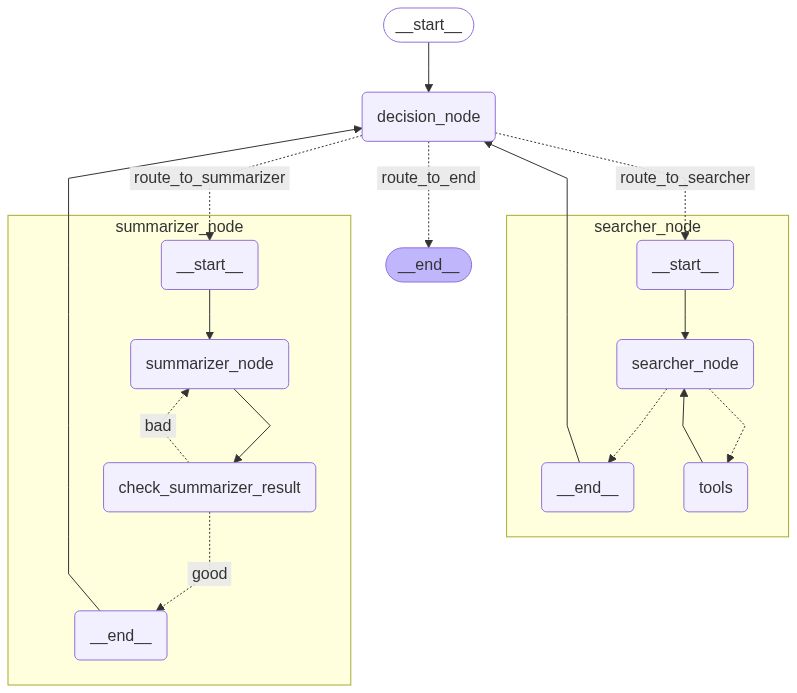

In [18]:
# Entry Graph
class State_agent_pattern(TypedDict):
    messages: Annotated[list, add_messages]  # Holds all messages: user query, tool calls/results, summaries
    agent_decision: str  # Routing: "route_to_searcher", "route_to_summarizer", "route_to_end"

# Create the LLM model
llm_agent_pattern = ChatAnthropic(model="claude-3-7-sonnet-20250219", api_key=ANTHROPIC_TOKEN)

# Functions
def decision_function(state: State_agent_pattern) -> dict:
    """
    Decides the next action for the agent based on the current state of messages.
    Updates 'agent_decision' to route to the searcher, summarizer, or end the process.
    """
    current_messages = state.get("messages", [])
    next_route = "route_to_searcher"  # Default action

    if not current_messages:
        print("Warning: decision_function called with empty messages. Defaulting to search.")
        return {"agent_decision": "route_to_searcher"}

    last_message = current_messages[-1]

    if isinstance(last_message, ToolMessage):
        # Search results are available (ToolMessage). Next step: summarize.
        next_route = "route_to_summarizer"
    elif isinstance(last_message, AIMessage):
        # AIMessage could be a direct answer from searcher or a summary from summarizer.
        ai_content = getattr(last_message, 'content', "").strip()

        if not ai_content:
            print("Warning: AIMessage has no content. Defaulting to search.")
            next_route = "route_to_searcher"
        else:
            # Use LLM to evaluate the AIMessage content
            system_prompt_eval = """You are an expert content analyst.
Analyze the provided text. The text could be a direct answer to a query or a summary.
- If the text is a comprehensive and sufficient final answer, respond with "enough".
- If the text seems like raw search results that were not properly captured as a ToolMessage but as an AIMessage, or requires summarization, respond with "needs_summary".
- If the text is a summary, but it's insufficient and more searching/refinement is needed, respond with "search_again".
Respond with only one of: "enough", "needs_summary", "search_again".
"""
            eval_messages = [
                SystemMessage(content=system_prompt_eval),
                HumanMessage(content=ai_content)
            ]
            try:
                llm_eval_decision_obj = llm_agent_pattern.invoke(eval_messages)
                eval_decision_str = llm_eval_decision_obj.content.strip().lower()

                if eval_decision_str == "enough":
                    next_route = "route_to_end"
                elif eval_decision_str == "needs_summary":
                    next_route = "route_to_summarizer"
                elif eval_decision_str == "search_again":
                    next_route = "route_to_searcher"
                else:
                    print(f"Warning: LLM in decision_function (AIMessage eval) returned: '{eval_decision_str}'. Defaulting to end.")
                    next_route = "route_to_end" # Safer default for unrecognized LLM output
            except Exception as e:
                print(f"Error during LLM call in decision_function: {e}. Defaulting to search.")
                next_route = "route_to_searcher"


    elif isinstance(last_message, HumanMessage):
        # Initial user query or a follow-up. Start by searching.
        next_route = "route_to_searcher"
    else:
        print(f"Warning: decision_function encountered an unexpected last message type: {type(last_message)}. Defaulting to search.")
        next_route = "route_to_searcher"

    return {"agent_decision": next_route}

# Build the graph
agent_pattern_builder = StateGraph(State_agent_pattern)

# Add nodes
agent_pattern_builder.add_node("decision_node", decision_function)
agent_pattern_builder.add_node("searcher_node", graph_searcher.compile())
agent_pattern_builder.add_node("summarizer_node", graph_summarizer.compile())

# Add edges
agent_pattern_builder.add_edge(START, "decision_node")
agent_pattern_builder.add_conditional_edges(
    source="decision_node",
    path=lambda state: state["agent_decision"],
    path_map={
        "route_to_searcher": "searcher_node",
        "route_to_summarizer": "summarizer_node",
        "route_to_end": END
    }
)

# Edges to loop back to the decision node after search or summarization
agent_pattern_builder.add_edge("searcher_node", "decision_node")
agent_pattern_builder.add_edge("summarizer_node", "decision_node")


# Compile the graph
graph_agent_pattern = agent_pattern_builder.compile()

# Setting xray to 1 will show the internal structure of the nested graph
try:
    display(Image(graph_agent_pattern.get_graph(xray=1).draw_mermaid_png()))
except Exception as e:
    print(f"Error al visualizar el grafo: {e}")

Vamos a probarlo preguntando por [Jules](https://jules.google/) un agente de codificación asíncrono que ha salido hace una semana (a fecha de escritura del post), por lo que obviamente no debería estar en el conocimiento del LLM.

In [19]:
from langchain_core.messages import HumanMessage, AIMessage

USER2_THREAD_ID = "2"
config_USER2 = {"configurable": {"thread_id": USER2_THREAD_ID}}

prompt = "Can you explain me what is Jules asyncronous coding agent?"

messages = [HumanMessage(content=prompt)]

result_agent_pattern = graph_agent_pattern.invoke({"messages": messages}, config=config_USER2)

for message in result_agent_pattern["messages"]:
    message.pretty_print()

================================ Human Message =================================

Can you explain me what is Jules asyncronous coding agent?
================================== Ai Message ==================================

[{'text': "I'll need to search for up-to-date information about Jules asynchronous coding agent since this appears to be a specific technology or tool that I should provide accurate information about.", 'type': 'text'}, {'id': 'toolu_01473AZcTAMVypoiFRbgZgfs', 'input': {'query': 'Jules asynchronous coding agent AI developer tool'}, 'name': 'tavily_search_results_json', 'type': 'tool_use'}]
Tool Calls:
  tavily_search_results_json (toolu_01473AZcTAMVypoiFRbgZgfs)
 Call ID: toolu_01473AZcTAMVypoiFRbgZgfs
  Args:
    query: Jules asynchronous coding agent AI developer tool
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "Jules - AI Agent Store", "url": "https://aiagentstore.ai/ai-agent/jules",

Tenemos un resumen de lo que es Jules, vamos a imprimirlo

In [20]:
result_agent_pattern["messages"][-1].pretty_print()

================================== Ai Message ==================================

Based on the search results, I can provide you with a comprehensive explanation of Jules, Google's asynchronous coding agent:

# Jules: Google's Asynchronous Coding Agent

Jules is an AI-powered coding agent developed by Google that works asynchronously to handle software development tasks. Unlike interactive coding assistants that provide real-time suggestions as you type, Jules operates independently in the background, allowing developers to focus on more complex or creative aspects of coding.

## Key Features and Capabilities:

1. **Asynchronous Operation**: Instead of working alongside you in real-time, Jules takes on assigned tasks and works on them independently, delivering completed work when finished.

2. **Task Handling**: Jules can autonomously manage various software development tasks including:
   - Bug fixes
   - Writing and implementing tests
   - Building new features
   - Bumping dependenc